Author: eyluelnaz.oezcan01@universitadipavia.it


Inspired by this [notebook](https://colab.research.google.com/drive/1KE2UTdlZIsgGDz7bNN5qOPK1gu0jk25R?usp=sharing)

This notebook implements a Denoising Diffusion Probabilistic Model (DDPM) to perform image inpainting on the MNIST dataset, focusing on scenarios where parts of the image are missing (masked). It includes temporal conditioning, U-Net architecture with attention, and sinusoidal timestep embeddings.

##Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

##Dataset and Masking Strategy

I used the MNIST dataset as a simple and interpretable benchmark for evaluating inpainting performance. The dataset is wrapped in a custom MaskedMNIST class that applies masking. Two masking strategies are implemented:

1.   half-image masking, where either the left or right half of the image is zeroed out,
2.   bounding-box masking, where a central region encompassing the digit is masked using a dynamically computed bounding box.

These masking functions simulate different degrees of structural damage and provide a way to assess the model’s ability to infer semantics from partial context.

In [ ]:
class MaskedMNIST(Dataset):
    def __init__(self, train=True, mask_fn=None):
        transform = transforms.Compose([
            transforms.ToTensor(), # [0,1]
            transforms.Normalize((0.5,), (0.5,)) # avg=0, std=1
        ])
        self.data = torchvision.datasets.MNIST(root='./data', train=train, download=True, transform=transform)

        self.mask_fn = mask_fn if mask_fn is not None else self.mask_center

    def mask_center(self, img, size=10): # applies masking to the central region of the image (10×10)
        img = img.clone() # copy of the org image
        _, H, W = img.shape
        start = (H - size) // 2
        img[:, start:start + size, start:start + size] = 0
        return img

    def __getitem__(self, idx):
        img, _ = self.data[idx]
        mask = self.mask_fn(img)
        masked = img * mask
        return masked, img, mask

    def __len__(self):
        return len(self.data)

### Half-Image Masking

In [ ]:
def mask_half_image(img, side='left'):
    _, H, W = img.shape
    mask = torch.ones_like(img)

    if side == 'left':
        mask[:, :, :W // 2] = 0
    elif side == 'right':
        mask[:, :, W // 2:] = 0
    else:
        raise ValueError("side must be 'left' or 'right'")
    return mask

### Bounding-Box Masking

In [ ]:
def get_bbox_mask(img, block_size=8):
    # img: [1, H, W]
    binary = (img > 0.1).float()
    coords = binary.nonzero(as_tuple=False)

    if coords.numel() == 0:
        return torch.ones_like(img)  # fallback if all zeros

    _, y_min, x_min = coords.min(dim=0)[0]
    _, y_max, x_max = coords.max(dim=0)[0]

    center_y = (y_min + y_max) // 2
    center_x = (x_min + x_max) // 2

    top = max(center_y - block_size // 2, 0)
    left = max(center_x - block_size // 2, 0)

    mask = torch.ones_like(img)
    mask[:, top:top+block_size, left:left+block_size] = 0
    return mask

##Sinusoidal Positional Embeddings

To ensure the model is aware of the current timestep 𝑡 in the denoising process, I encode it using sinusoidal positional embeddings, as introduced in the paper "[Attention Is All You Need](https://arxiv.org/abs/1706.03762)" by Vaswani et al. (2017). These embeddings are deterministic and enable the model to generalize to arbitrary timesteps during training and inference.

The sinusoidal embeddings are defined as:
$$
\text{PE}_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right), \quad
\text{PE}_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

Specifically, a time embedding vector is generated for each 𝑡, projected through a multi-layer perceptron, and added to the latent representation in the U-Net bottleneck. This conditioning enables the model to adapt its behavior across different noise levels and improves convergence by providing explicit temporal context.

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, timesteps):
        device = timesteps.device
        half_dim = self.embedding_dim // 2
        emb = torch.exp(torch.arange(half_dim, device=device) * -(np.log(10000.0) / (half_dim - 1)))
        emb = timesteps[:, None] * emb[None, :]
        # [B, 1], [1, half_dim]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1) # [B, embedding_dim]

##U-Net Architecture with Self-Attention

The backbone of the model is a U-Net architecture. U-Net comprises an encoder-decoder structure with skip connections that preserve spatial information lost during downsampling.

In my design, the U-Net is enhanced with self-attention layers in the bottleneck, enabling the model to capture long-range dependencies even in small 28×28 images. This is particularly useful in inpainting, where the missing region may depend on distant parts of the image. Self-attention is implemented via query-key-value projections followed by scaled dot-product attention, allowing global interactions across the entire image space.

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.qkv = nn.Conv2d(in_channels, in_channels * 3, kernel_size=1)
        self.out_proj = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(x) # [B, 3*C, H, W]
        q, k, v = torch.chunk(qkv, 3, dim=1)

        q = q.reshape(B, C, H * W).permute(0, 2, 1)  # (B, HW, C)
        k = k.reshape(B, C, H * W)                  # (B, C, HW)
        v = v.reshape(B, C, H * W).permute(0, 2, 1)  # (B, HW, C)

        attn = torch.softmax(torch.bmm(q, k) / np.sqrt(C), dim=-1)  # (B, HW, HW)
        out = torch.bmm(attn, v).permute(0, 2, 1).reshape(B, C, H, W)

        return self.out_proj(out + x)  # residual connection

In [ ]:
class UNetWithTime(nn.Module):
    def __init__(self):
        super(UNetWithTime, self).__init__()
        self.in_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc1 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.enc2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.middle = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.attn = SelfAttention(256)

        self.time_mlp = SinusoidalPositionEmbeddings(64)
        self.time_embed = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )

        self.dec1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1)
        self.out = nn.Conv2d(128, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        x1 = F.relu(self.in_conv(x))
        x2 = F.relu(self.enc1(x1))
        x3 = F.relu(self.enc2(x2))

        t_emb = self.time_mlp(t) # [B] -> [B, 64]
        t_emb = self.time_embed(t_emb)[:, :, None, None] # [B, 256, 1, 1]

        x3 = F.relu(self.middle(x3) + t_emb)
        x3 = self.attn(x3)

        d1 = F.relu(self.dec1(x3))
        d1 = torch.cat([d1, x2], dim=1)  # skip connection -> [B, 256, 14, 14]
        d2 = F.relu(self.dec2(d1))
        d2 = torch.cat([d2, x1], dim=1) # skip connection -> [B, 128, 28, 28]

        out = torch.tanh(self.out(d2)) # tanh to normalize predictions to [-1, 1]
        # [B, 1, 28, 28]
        return out

##Diffusion Scheduler

The core of the DDPM framework involves two processes: the forward (diffusion) process and the reverse (denoising) process. In the forward process, Gaussian noise is incrementally added to the data over a fixed number of timesteps, turning a clean image into nearly pure noise. The reverse process, learned by the model, attempts to invert this procedure by predicting the clean image given a noisy one.

In my implementation, the noise schedule is governed by a cosine-based beta schedule, inspired by Nichol & Dhariwal (2021), from the ["Improved Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2102.09672). This schedule is advantageous over linear beta schedules because it preserves more signal in the early steps and results in more stable training. Mathematically, we compute cumulative products of alphas, 𝛼, and use them to parameterize the noisy image at timestep t as:

$$
\bar{\alpha}_t = \frac{f(t)}{f(0)}, \quad \text{where} \quad f(t) = \cos\left( \frac{t/T + s}{1 + s} \cdot \frac{\pi}{2} \right)^2
$$

This formulation allows the model to learn denoising mappings by minimizing the expected reconstruction loss over masked regions.



In [ ]:
class DiffusionScheduler:
    def __init__(self, timesteps=200):
        self.timesteps = timesteps
        steps = torch.arange(timesteps + 1)
        alphas_cumprod = torch.cos((steps / timesteps + 0.008) / 1.008 * torch.pi / 2) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

        self.alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
        self.betas = 1 - self.alphas
        self.alpha_hats = torch.cumprod(self.alphas, dim=0)

    def get_params(self, t):
        return self.betas[t], self.alphas[t], self.alpha_hats[t]

##Training Procedure

The model is trained to condition on the visible pixels and only reconstruct the missing regions. This is achieved by creating a hybrid input at each timestep:

$$
\quad \tilde{x}_t = x_t \cdot (1 - m) + x_{\text{masked}} \cdot m
$$

where
m is the binary mask indicating observed pixels. The model then predicts
𝑥0 and the loss is computed only over the unobserved region:

$$
{L}_{\text{MSE}} = \left\| (\hat{x}_0 - x_0) \cdot (1 - m) \right\|^2
$$

This masked loss ensures that the model does not modify the known parts and focuses on plausible generation for the occluded area. The training process minimizes this loss over randomly sampled timesteps, allowing the model to learn to denoise under various noise conditions.

In [ ]:
def train(model, dataloader, optimizer, scheduler, device, epochs=30):
    model.train()
    losses = []
    for epoch in range(epochs):
        pbar = tqdm(dataloader)
        for masked, original, mask in pbar:
            t = torch.randint(0, scheduler.timesteps, (masked.size(0),), device=device).long()
            noise = torch.randn_like(original)

            alpha_hat = scheduler.alpha_hats[t].view(-1, 1, 1, 1)
            x_noisy = torch.sqrt(alpha_hat) * original + torch.sqrt(1 - alpha_hat) * noise
            noisy_input = x_noisy * (1 - mask) + masked * mask

            pred_img = model(noisy_input, t)
            loss = F.mse_loss(pred_img * (1 - mask), original * (1 - mask))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            pbar.set_description(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    return losses


##Sampling / Inpainting Procedure

After training, image reconstruction (inpainting) is performed using the reverse diffusion process. Starting from pure Gaussian noise, the model iteratively predicts cleaner versions of the image. At each timestep, the model receives a hybrid input that preserves the known pixels and updates the missing regions.

The denoised estimate
$\hat{x}_0$ is used to compute the next noisy image as:
$$
x_{t-1} = \sqrt{\bar{\alpha}_t} \cdot \hat{x}_0 + \sqrt{1 - \bar{\alpha}_t} \cdot z
$$

where $𝑧∼𝑁 (0,𝐼)$ if $𝑡>0$, and $𝑧=0$ otherwise.

After each step, the known pixels from the masked input are re-inserted to ensure conditioning is preserved throughout the process.





In [ ]:
@torch.no_grad()
def sample_inpainting(model, scheduler, masked_imgs, original_imgs, mask, device):
    model.eval()
    x = torch.randn_like(masked_imgs).to(device)

    for t in reversed(range(scheduler.timesteps)):
        time = torch.full((masked_imgs.size(0),), t, device=device, dtype=torch.long)
        x0_pred = model(x * (1 - mask) + masked_imgs * mask, time)

        beta_t, _, alpha_hat_t = scheduler.get_params(t)
        beta_t = beta_t.to(device).view(-1, 1, 1, 1)
        alpha_hat_t = alpha_hat_t.to(device).view(-1, 1, 1, 1)


        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = torch.sqrt(alpha_hat_t) * x0_pred + torch.sqrt(1 - alpha_hat_t) * noise
        x = x * (1 - mask) + masked_imgs * mask

    return x

##Visualization Functions

In [ ]:
def show_images(masked, original, reconstructed):
    masked = torch.clamp(masked * 0.5 + 0.5, 0, 1)
    original = torch.clamp(original * 0.5 + 0.5, 0, 1)
    reconstructed = torch.clamp(reconstructed * 0.5 + 0.5, 0, 1)
    fig, axs = plt.subplots(3, masked.size(0), figsize=(masked.size(0)*2, 6))
    for i in range(masked.size(0)):
        axs[0, i].imshow(masked[i].squeeze().cpu(), cmap='gray')
        axs[1, i].imshow(original[i].squeeze().cpu(), cmap='gray')
        axs[2, i].imshow(reconstructed[i].squeeze().cpu(), cmap='gray')
        axs[0, i].set_title("Masked")
        axs[1, i].set_title("Original")
        axs[2, i].set_title("Inpainted")
        for ax in axs[:, i]:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_loss(losses):
    import matplotlib.pyplot as plt
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.show()

##Training and Evaluation

###Experiment 1

Trained on left-half masked digits and evaluated using DDPM sampling conditioned on observed right-half.

Epoch 30, Loss: 0.0178: 100%|██████████| 469/469 [11:57<00:00,  1.53s/it]


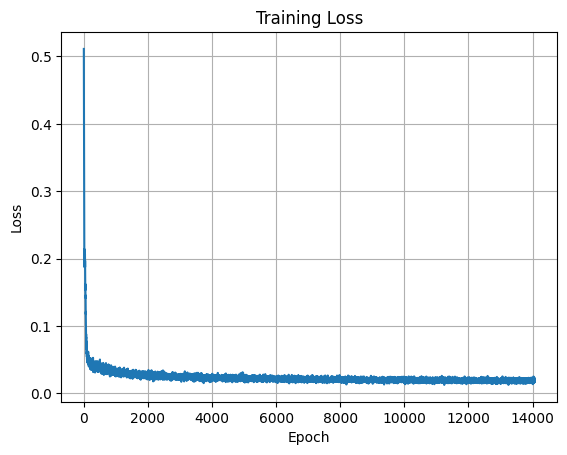

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = MaskedMNIST(train=True, mask_fn=lambda img: mask_half_image(img, side='left'))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

model = UNetWithTime().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = DiffusionScheduler(timesteps=200)

losses = train(model, dataloader, optimizer, scheduler, device, epochs=30)
plot_loss(losses)

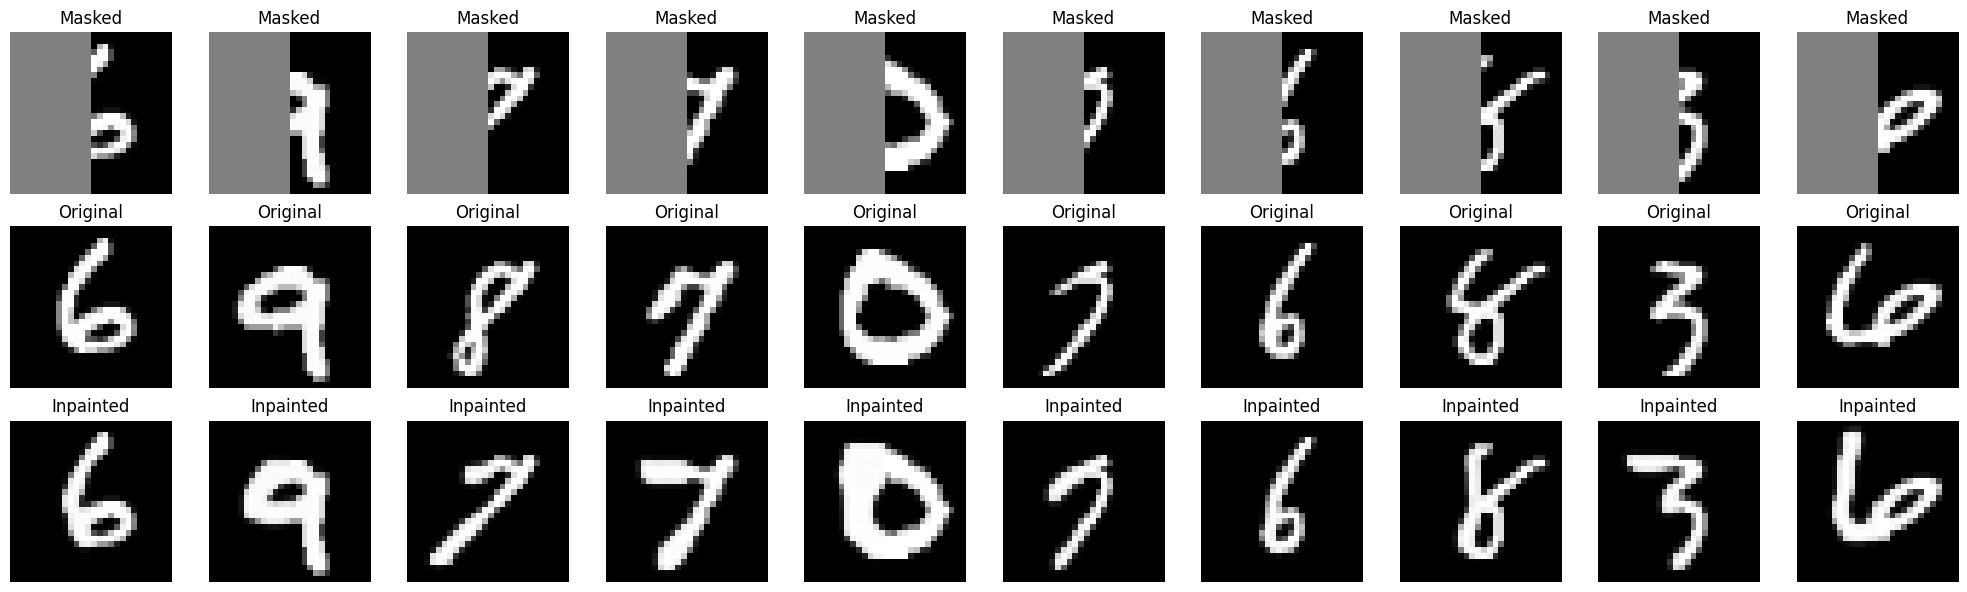

In [ ]:
testset = MaskedMNIST(train=False, mask_fn=lambda img: mask_half_image(img, side='left'))
testloader = DataLoader(testset, batch_size=10, shuffle=True)

masked, original, mask = next(iter(testloader))
masked, original, mask = masked.to(device), original.to(device), mask.to(device)
reconstructed = sample_inpainting(model, scheduler, masked, original, mask, device)

show_images(masked, original, reconstructed)

###Experiment 2

Trained with digit-centered bbox masking for more localized inpainting.





Epoch 20, Loss: 0.0065: 100%|██████████| 469/469 [10:45<00:00,  1.38s/it]


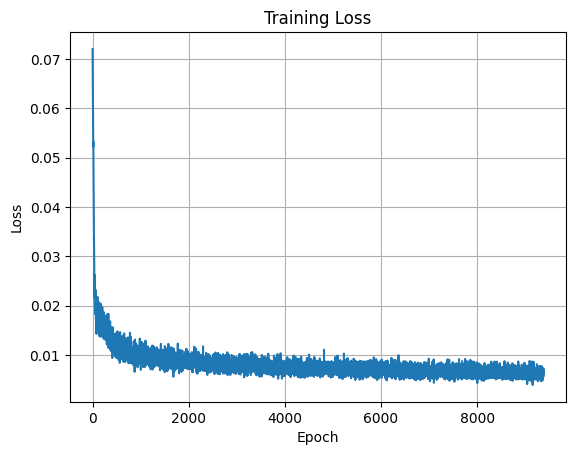

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = MaskedMNIST(train=True, mask_fn=get_bbox_mask)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

model = UNetWithTime().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = DiffusionScheduler(timesteps=200)

losses = train(model, dataloader, optimizer, scheduler, device, epochs=20)
plot_loss(losses)

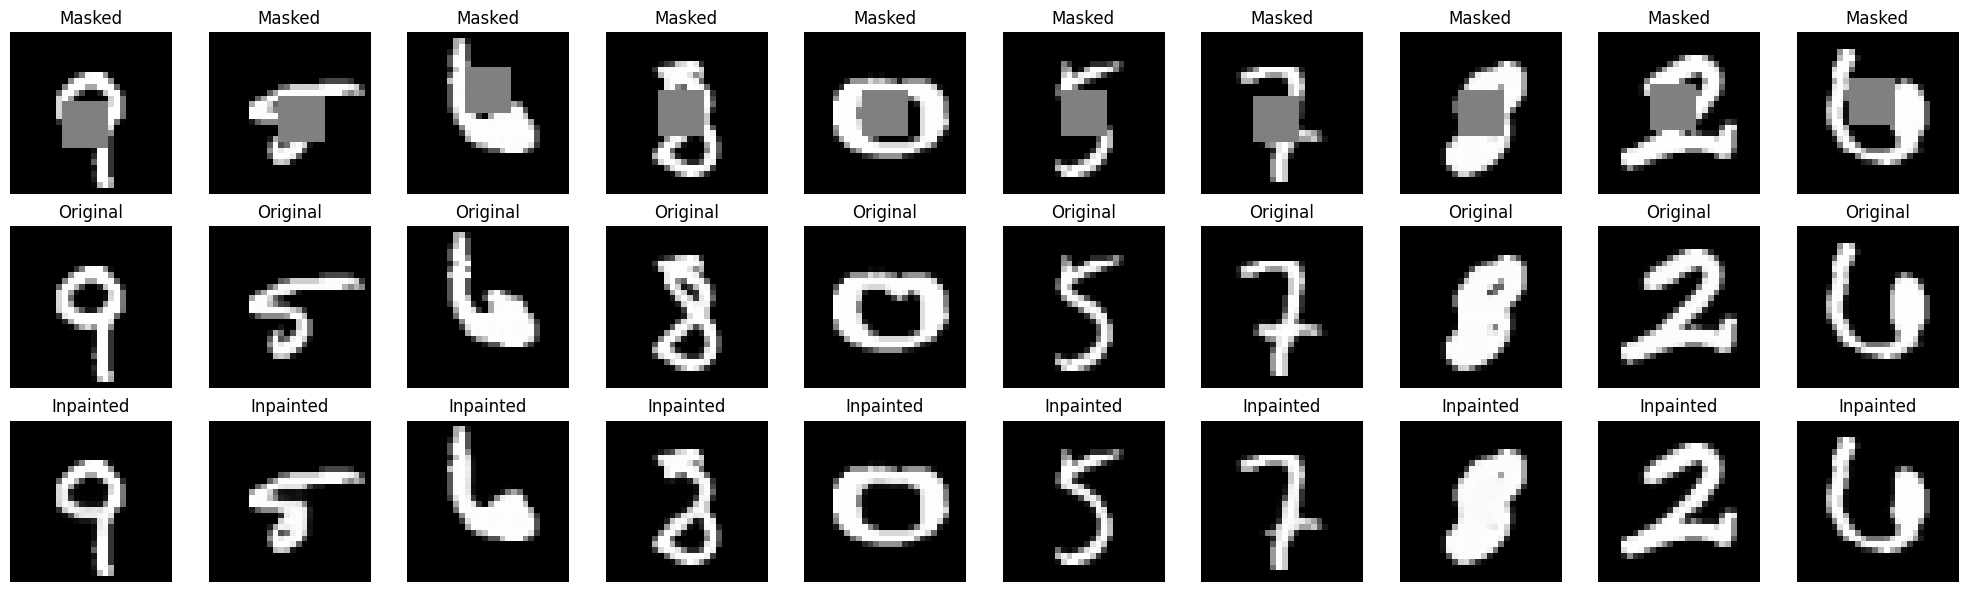

In [ ]:
testset = MaskedMNIST(train=False, mask_fn=get_bbox_mask)
testloader = DataLoader(testset, batch_size=10, shuffle=True)

masked, original, mask = next(iter(testloader))
masked, original, mask = masked.to(device), original.to(device), mask.to(device)
reconstructed = sample_inpainting(model, scheduler, masked, original, mask, device)

show_images(masked, original, reconstructed)